In [1]:
%reload_ext autoreload
%autoreload 2

import json
import math
import os

import tqdm
import torch
import pyro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
from typing import Dict, Optional, NamedTuple

import mira
import mira.metamodel.io
import mira.modeling
import mira.modeling.viz
import mira.sources.petri

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, PetriNetODESystem, Time, State, Solution, Observation, get_name
from pyciemss.utils import state_flux_constraint

pyro.settings.set(module_local_params=True)
pyro.set_rng_seed(0)
pyro.clear_param_store()

In [2]:
class Scenario3Model(PetriNetODESystem):

    def __init__(self, G, *, noise_scale: float = 1):
        super().__init__(G)
        self.register_buffer("noise_scale", torch.as_tensor(noise_scale))

        # set priors on the rate parameters
        for param in self.G.parameters.values():
            prior_loc = torch.log(torch.as_tensor(param.value if param.value is not None else 0.01))
            prior_scale = torch.as_tensor(0.1)
            setattr(self, get_name(param), pyro.nn.PyroSample(dist.LogNormal(prior_loc, prior_scale)))

        # set priors on the initial state at the start of the training window
        for var in self.G.variables.values():
            prior_loc = torch.log(torch.as_tensor(var.data["initial_value"]))
            prior_scale = torch.as_tensor(1.)
            setattr(
                self,
                f"default_initial_state_{get_name(var)}",
                pyro.nn.PyroSample(dist.LogNormal(prior_loc, prior_scale))
            )
       
    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        data = {} if data is None else data
        output = []
        for name, value in zip(self.var_order, solution):
            output.append(pyro.sample(
                name,
                dist.Normal(value, self.noise_scale).to_event(1),
                obs=data.get(name, None),
            ))
        return tuple(output)


In [3]:
MODEL_PATH = "../../../program-milestones/6-month-milestone/evaluation/"

MODEL_FILES = {
    "biomd958": (
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd958.json"),
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd958_mira.json"),
    ),
    "biomd960": (
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd960.json"),
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd960_mira.json"),
    ),
    "sir": (
        os.path.join(MODEL_PATH, "scenario_1/ta_2/scenario1_sir.json"),
        os.path.join(MODEL_PATH, "scenario_1/ta_2/scenario1_sir_mira.json"),
    ),
}

DATA_ALIGNMENTS = {
    "biomd958": {
        "I": "Infectious",
        "H": "Hospitalised",
        "R": "Recovered",
        "D": "Fatalities",
    },
    "biomd960": {
        "I": "Infectious",
        "H": "Hospitalized",
        "R": "Recovered",
        "D": "Deceased",
    },
    "sir": {
        "I": "infected_population",
        "R": "immune_population",
    },
}

DATA_SCALE = {
    "biomd958": 1e3,
    "biomd960": 1.,
    "sir": 1e7,
}

def load_data(filename, model_name, interval: Optional[tuple] = None):
    df = pd.read_csv(filename)
    alignment = DATA_ALIGNMENTS[model_name]

    dates = pd.to_datetime(df["date"])
    
    if interval is not None:
        start, end = interval
        dates_mask = (dates >= start) & (dates <= end)

    tspan = torch.as_tensor(np.array(
        ((dates[dates_mask] if interval is not None else dates) - dates.iloc[0]).dt.total_seconds() / (24 * 60 * 60)
    ))

    obs = {
        alignment[col]: torch.tensor(
            (df[col][dates_mask] if interval is not None else df[col]).values
        ) / DATA_SCALE[model_name]
        for col in df.columns if col in alignment
    }

    return tspan, obs

In [ ]:
def infer_parameters_advi(model, guide, optimizer, data, tspan, num_iterations, **optim_params):

    loss_fn = pyro.infer.Trace_ELBO()(model, guide)

    optimizer = torch.optim.Adam(loss_fn.parameters(), **optim_params)

    # initialize parameters
    with torch.no_grad():
        loss_fn(None, tspan, data)

    for i in range(num_iterations):
        optimizer.zero_grad()
        loss = loss_fn(None, tspan, data)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"iteration {i}: loss = {loss.item()}")

## Basic SIR model

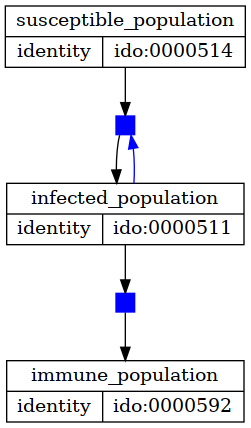

In [5]:
MODEL_NAME = "sir"

DATA_FILE = "usa-IRDVHN_age.csv"
TRAIN_INTERVAL = (pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-30"))
TEST_INTERVAL = (pd.to_datetime("2021-10-01"), pd.to_datetime("2022-01-01"))

model = Scenario3Model.from_mira(MODEL_FILES[MODEL_NAME][0])
model.noise_scale = pyro.nn.PyroSample(dist.LogNormal(0, 1))  #10. / DATA_SCALE[MODEL_NAME])

full_tspan, full_data = load_data(DATA_FILE, MODEL_NAME)
train_tspan, train_data = load_data(DATA_FILE, MODEL_NAME, TRAIN_INTERVAL)
test_tspan, test_data = load_data(DATA_FILE, MODEL_NAME, TEST_INTERVAL)

mira.modeling.viz.GraphicalModel.for_jupyter(model.G.template_model, name=f"viz_{MODEL_NAME}.png")

Initial state:  {'immune_population': tensor(14.0077), 'infected_population': tensor(1.4914), 'susceptible_population': tensor(0.1132)}


,Unnamed: 0,I,R,D,V,H,I_0-9,I_10-19,I_20-29,I_30-39,...,N_10-19,N_20-29,N_30-39,N_40-49,N_50-59,N_60-69,N_70-79,N_80-89,N_90-99,N_100+
count,629.00000,6.290000e+02,6.290000e+02,629.000000,6.290000e+02,629.000000,629.000000,6.290000e+02,6.290000e+02,6.290000e+02,...,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0
mean,314.00000,1.824148e+06,5.028726e+07,698484.737679,1.926294e+08,45946.521463,134016.499205,2.044128e+05,2.812316e+05,2.721816e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
std,181.72094,1.978525e+06,2.344204e+07,209485.974357,7.940621e+07,33017.880513,144782.838801,2.127507e+05,2.919734e+05,2.720895e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,1.793920e+05,1.329420e+07,253207.000000,3.081700e+04,0.000000,16245.000000,3.466000e+04,5.042200e+04,4.513700e+04,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
25%,157.00000,7.973120e+05,3.146800e+07,548324.000000,1.665916e+08,26372.000000,57118.000000,9.849300e+04,1.384470e+05,1.338750e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
50%,314.00000,1.397172e+06,4.320442e+07,684485.000000,2.199655e+08,37921.000000,97126.000000,1.429680e+05,2.006480e+05,1.978420e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
75%,471.00000,1.940458e+06,7.726970e+07,930841.000000,2.557774e+08,61421.000000,147339.000000,2.180180e+05,2.937820e+05,2.896690e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
max,628.00000,1.129407e+07,9.058354e+07,995401.000000,2.631494e+08,133263.000000,892161.000000,1.338296e+06,1.784822e+06,1.613565e+06,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0


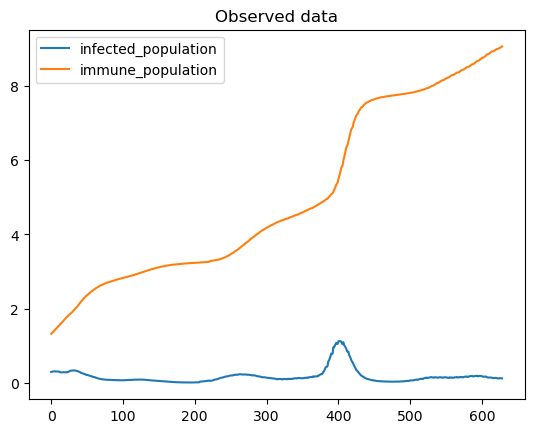

In [6]:
for name, col in full_data.items():
    plt.plot(full_tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

In [7]:
guide = pyro.infer.autoguide.AutoLowRankMultivariateNormal(pyro.poutine.block(model, hide=list(model.var_order.keys())))
infer_parameters_advi(model, guide, train_data, train_tspan, 500, lr=1e-2)

/home/eli/development/pyro/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'susceptible_population'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


iteration 0: loss = 524.6644287109375
iteration 10: loss = 112.01741027832031
iteration 20: loss = 78.81062316894531
iteration 30: loss = 71.88646697998047
iteration 40: loss = 43.71949768066406
iteration 50: loss = 93.26373291015625
iteration 60: loss = 25.622282028198242
iteration 70: loss = -9.129353523254395
iteration 80: loss = -34.98680877685547
iteration 90: loss = -46.680240631103516
iteration 100: loss = -45.20899200439453
iteration 110: loss = -32.892887115478516
iteration 120: loss = -33.70673370361328
iteration 130: loss = -42.45882034301758
iteration 140: loss = -46.591896057128906
iteration 150: loss = -33.458072662353516
iteration 160: loss = -52.169647216796875
iteration 170: loss = -54.62239456176758
iteration 180: loss = -45.46107482910156
iteration 190: loss = -41.71647644042969
iteration 200: loss = -43.17577362060547
iteration 210: loss = -36.820106506347656
iteration 220: loss = -47.38987350463867
iteration 230: loss = -52.903621673583984
iteration 240: loss = -18

Text(0.5, 1.0, "Posterior predictive distribution for model sir (approx: <class 'pyro.infer.autoguide.guides.AutoLowRankMultivariateNormal'>)")

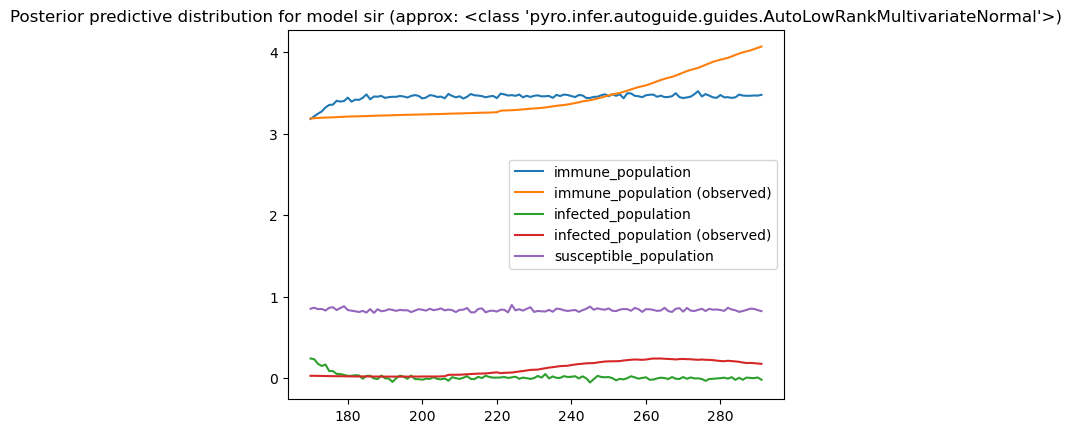

In [10]:
result = sample(model, 100, None, train_tspan, guide)

for name in result.keys():
    plt.plot(train_tspan, result[name].mean(0).detach().numpy(), label=name)
    if name in train_data:
        plt.plot(train_tspan, train_data[name].detach().numpy(), label=name + " (observed)")
plt.legend()
plt.title(f"Posterior predictive distribution for model {MODEL_NAME} (approx: {type(guide)})")

## Model with asymptomatic cases and hospitalization

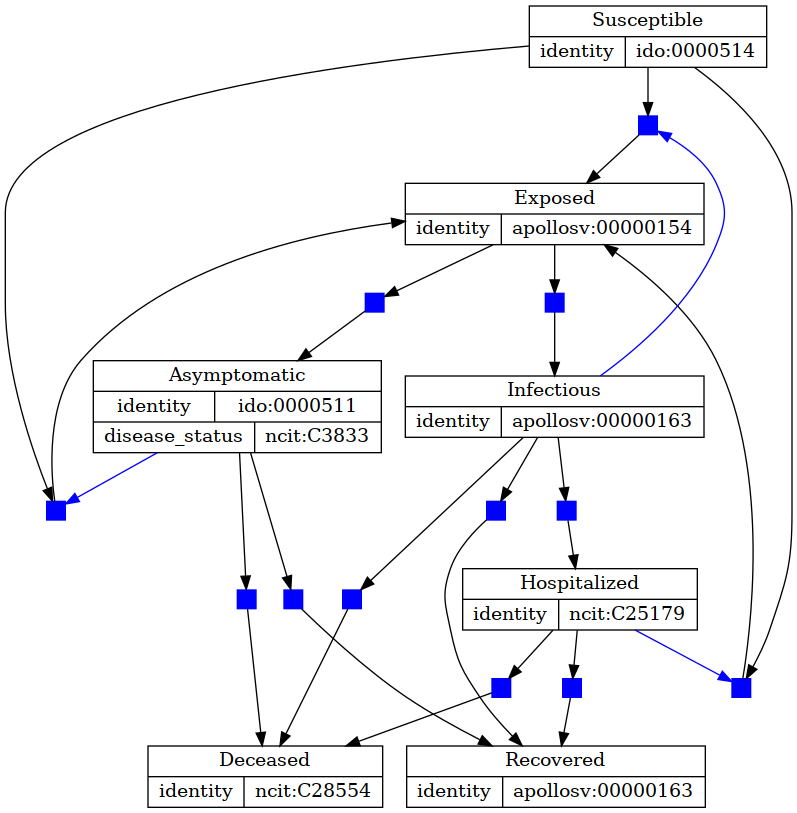

In [18]:
MODEL_NAME = "biomd960"

DATA_FILE = "usa-IRDVHN_age.csv"
TRAIN_INTERVAL = (pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-30"))
TEST_INTERVAL = (pd.to_datetime("2021-10-01"), pd.to_datetime("2022-01-01"))

model = Scenario3Model.from_mira(MODEL_FILES[MODEL_NAME][0])
model.noise_scale = pyro.nn.PyroSample(dist.LogNormal(math.log(1e7), 7))  #10. / DATA_SCALE[MODEL_NAME])

mira.modeling.viz.GraphicalModel.for_jupyter(model.G.template_model, name=f"viz_{MODEL_NAME}.png")

Initial state:  {'Asymptomatic': tensor(1574.7040), 'Deceased': tensor(0.), 'Exposed': tensor(48999.4961), 'Hospitalized': tensor(0.), 'Infectious': tensor(2719.8860), 'Recovered': tensor(0.), 'Susceptible': tensor(12331050.)}


,Unnamed: 0,I,R,D,V,H,I_0-9,I_10-19,I_20-29,I_30-39,...,N_10-19,N_20-29,N_30-39,N_40-49,N_50-59,N_60-69,N_70-79,N_80-89,N_90-99,N_100+
count,629.00000,6.290000e+02,6.290000e+02,629.000000,6.290000e+02,629.000000,629.000000,6.290000e+02,6.290000e+02,6.290000e+02,...,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0
mean,314.00000,1.824148e+06,5.028726e+07,698484.737679,1.926294e+08,45946.521463,134016.499205,2.044128e+05,2.812316e+05,2.721816e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
std,181.72094,1.978525e+06,2.344204e+07,209485.974357,7.940621e+07,33017.880513,144782.838801,2.127507e+05,2.919734e+05,2.720895e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,1.793920e+05,1.329420e+07,253207.000000,3.081700e+04,0.000000,16245.000000,3.466000e+04,5.042200e+04,4.513700e+04,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
25%,157.00000,7.973120e+05,3.146800e+07,548324.000000,1.665916e+08,26372.000000,57118.000000,9.849300e+04,1.384470e+05,1.338750e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
50%,314.00000,1.397172e+06,4.320442e+07,684485.000000,2.199655e+08,37921.000000,97126.000000,1.429680e+05,2.006480e+05,1.978420e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
75%,471.00000,1.940458e+06,7.726970e+07,930841.000000,2.557774e+08,61421.000000,147339.000000,2.180180e+05,2.937820e+05,2.896690e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
max,628.00000,1.129407e+07,9.058354e+07,995401.000000,2.631494e+08,133263.000000,892161.000000,1.338296e+06,1.784822e+06,1.613565e+06,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0


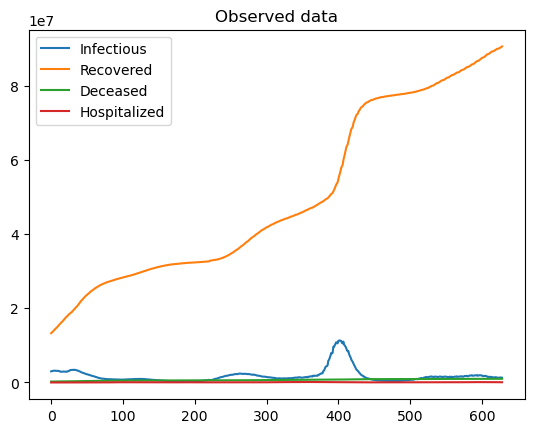

In [19]:
full_tspan, full_data = load_data(DATA_FILE, MODEL_NAME)
train_tspan, train_data = load_data(DATA_FILE, MODEL_NAME, TRAIN_INTERVAL)
test_tspan, test_data = load_data(DATA_FILE, MODEL_NAME, TEST_INTERVAL)

for name, col in full_data.items():
    plt.plot(full_tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

In [31]:
NUM_ITERATIONS = 500
OPTIM_PARAMS = {"lr": 1e-2}

# posterior = infer_parameters(model, NUM_ITERATIONS, [], data, initial_state, tspan)
guide = pyro.infer.autoguide.AutoDelta(
    pyro.poutine.block(model, hide=list(model.var_order.keys())),
    init_loc_fn=pyro.infer.autoguide.initialization.init_to_feasible,
)
optimizer = torch.optim.Adam(loss_fn.parameters(), **OPTIM_PARAMS)

for i in range(NUM_ITERATIONS):
    optimizer.zero_grad()
    loss = loss_fn(None, train_tspan, train_data)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"iteration {i}: loss = {loss.item()}")

ValueError: Expected parameter loc (Tensor of shape (122,)) of distribution Normal(loc: torch.Size([122]), scale: torch.Size([122])) to satisfy the constraint Real(), but found invalid values:
tensor([ 1.0000e+00,  2.0000e+00,  3.7500e-01,  3.5469e+00, -2.9946e+00,
         1.1056e+01, -1.6864e+01,  3.7433e+01, -8.8262e+01,  6.5571e+02,
         2.6766e+04, -6.8773e+06,  4.2884e+10,  7.2480e+13,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan])
                                                                                                                                                                              Trace Shapes:  
                                                                                                                                                                               Param Sites:  
                                                                                                                                                                              Sample Sites:  
                                                                                                                                                    default_initial_state_Asymptomatic dist |
                                                                                                                                                                                      value |
                                                                                                                                                         default_initial_state_Exposed dist |
                                                                                                                                                                                      value |
                                                                                                                                                      default_initial_state_Fatalities dist |
                                                                                                                                                                                      value |
                                                                                                                                                    default_initial_state_Hospitalised dist |
                                                                                                                                                                                      value |
                                                                                                                                                      default_initial_state_Infectious dist |
                                                                                                                                                                                      value |
                                                                                                                                                       default_initial_state_Recovered dist |
                                                                                                                                                                                      value |
                                                                                                                                                 default_initial_state_Super_spreaders dist |
                                                                                                                                                                                      value |
                                                                                                                                                     default_initial_state_Susceptible dist |
                                                                                                                                                                                      value |
rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Infectious', ('identity', 'apollosv:00000163')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
    rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Hospitalised', ('identity', 'ncit:C25179')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
 rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Super_spreaders', ('identity', 'ido:0000463')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
                   rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Asymptomatic', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C3833')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                  rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Super_spreaders', ('identity', 'ido:0000463')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                 rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Infectious', ('identity', 'apollosv:00000163')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             p_delta_p dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             a_gamma_a dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             i_gamma_i dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             i_delta_i dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             r_gamma_r dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             h_delta_h dist |
                                                                                                                                                                                      value |
                                                                                                                                                                           noise_scale dist |
                                                                                                                                                                                      value |
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
posterior_predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100, return_sites=list(model.var_order.keys()))
result = posterior_predictive(None, train_tspan)

for name in result.keys():
    if name in train_data:
        plt.plot(train_tspan, result[name].mean(0).detach().numpy(), label=name)
        plt.plot(train_tspan, train_data[name].detach().numpy(), label=name + " (observed)")
plt.legend()
plt.title(f"Posterior predictive distribution for model {MODEL_NAME} (approx: {type(guide)})")

## Model with asymptomatic and super-spreader infected individuals

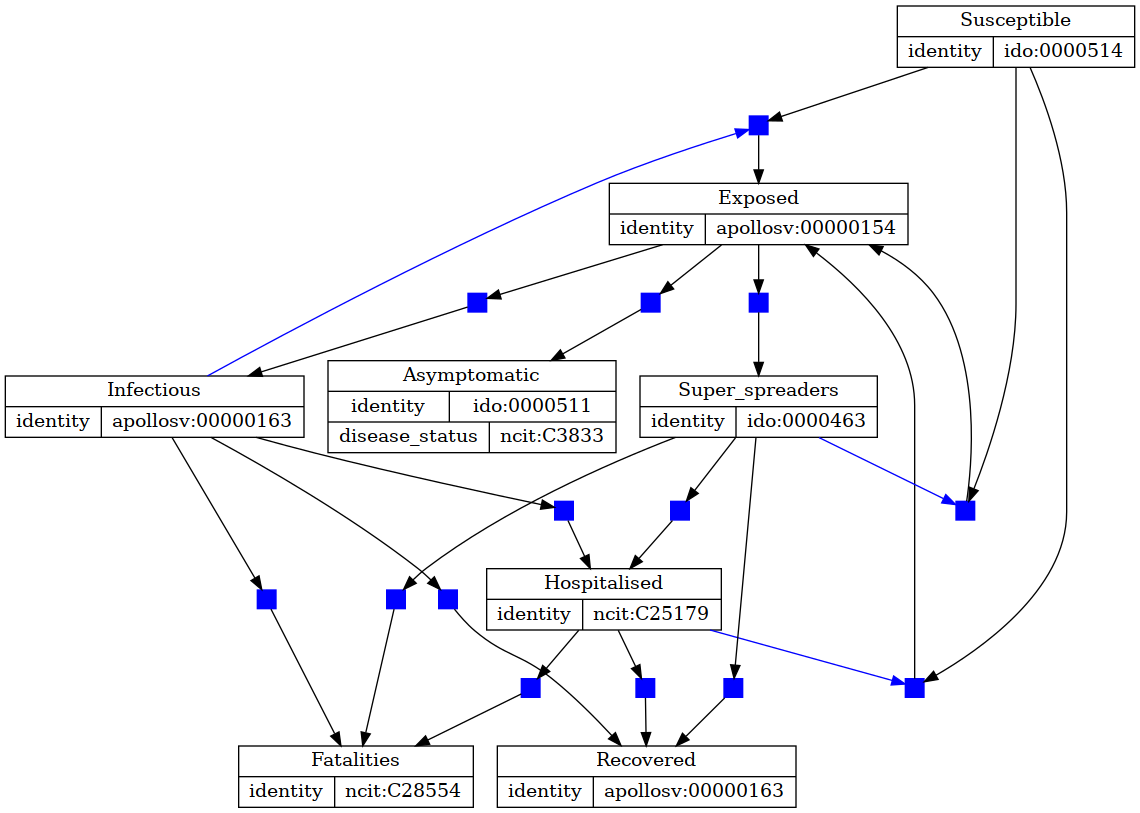

In [21]:
MODEL_NAME = "biomd958"

DATA_FILE = "usa-IRDVHN_age.csv"
TRAIN_INTERVAL = (pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-30"))
TEST_INTERVAL = (pd.to_datetime("2021-10-01"), pd.to_datetime("2022-01-01"))

model = Scenario3Model.from_mira(MODEL_FILES[MODEL_NAME][0])
model.noise_scale = pyro.nn.PyroSample(dist.LogNormal(0, 1))  #10. / DATA_SCALE[MODEL_NAME])

mira.modeling.viz.GraphicalModel.for_jupyter(model.G.template_model, name=f"viz_{MODEL_NAME}.png")

Initial state:  {'Asymptomatic': tensor(0.), 'Exposed': tensor(0.), 'Fatalities': tensor(0.), 'Hospitalised': tensor(0.), 'Infectious': tensor(3.9134), 'Recovered': tensor(0.), 'Super_spreaders': tensor(9.0323), 'Susceptible': tensor(39252.4922)}


,Unnamed: 0,I,R,D,V,H,I_0-9,I_10-19,I_20-29,I_30-39,...,N_10-19,N_20-29,N_30-39,N_40-49,N_50-59,N_60-69,N_70-79,N_80-89,N_90-99,N_100+
count,629.00000,6.290000e+02,6.290000e+02,629.000000,6.290000e+02,629.000000,629.000000,6.290000e+02,6.290000e+02,6.290000e+02,...,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0
mean,314.00000,1.824148e+06,5.028726e+07,698484.737679,1.926294e+08,45946.521463,134016.499205,2.044128e+05,2.812316e+05,2.721816e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
std,181.72094,1.978525e+06,2.344204e+07,209485.974357,7.940621e+07,33017.880513,144782.838801,2.127507e+05,2.919734e+05,2.720895e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,1.793920e+05,1.329420e+07,253207.000000,3.081700e+04,0.000000,16245.000000,3.466000e+04,5.042200e+04,4.513700e+04,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
25%,157.00000,7.973120e+05,3.146800e+07,548324.000000,1.665916e+08,26372.000000,57118.000000,9.849300e+04,1.384470e+05,1.338750e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
50%,314.00000,1.397172e+06,4.320442e+07,684485.000000,2.199655e+08,37921.000000,97126.000000,1.429680e+05,2.006480e+05,1.978420e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
75%,471.00000,1.940458e+06,7.726970e+07,930841.000000,2.557774e+08,61421.000000,147339.000000,2.180180e+05,2.937820e+05,2.896690e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
max,628.00000,1.129407e+07,9.058354e+07,995401.000000,2.631494e+08,133263.000000,892161.000000,1.338296e+06,1.784822e+06,1.613565e+06,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0


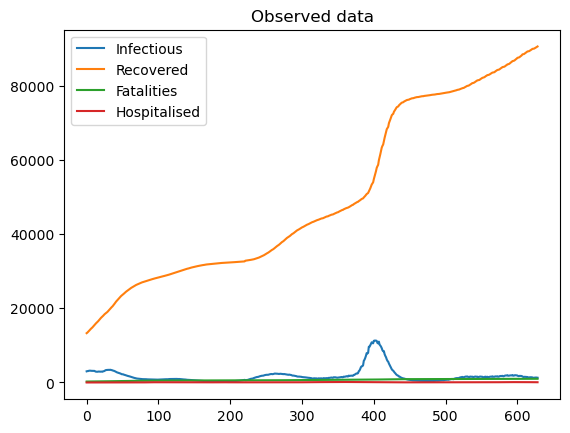

In [23]:
full_tspan, full_data = load_data(DATA_FILE, MODEL_NAME)
train_tspan, train_data = load_data(DATA_FILE, MODEL_NAME, TRAIN_INTERVAL)
test_tspan, test_data = load_data(DATA_FILE, MODEL_NAME, TEST_INTERVAL)

for name, col in full_data.items():
    plt.plot(full_tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

### Calibrate the model using data from the training window

In [28]:
pyro.clear_param_store()
NUM_ITERATIONS = 500
OPTIM_PARAMS = {"lr": 1e-4}

# posterior = infer_parameters(model, NUM_ITERATIONS, [], data, initial_state, tspan)
guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, hide=list(model.var_order.keys())))
loss_fn = pyro.infer.Trace_ELBO()(model, guide)

# initialize parameters
with torch.no_grad():
    loss_fn(None, train_tspan, train_data)

optimizer = torch.optim.Adam(loss_fn.parameters(), **OPTIM_PARAMS)

for i in range(NUM_ITERATIONS):
    optimizer.zero_grad()
    loss = loss_fn(None, train_tspan, train_data)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"iteration {i}: loss = {loss.item()}")

ValueError: Expected parameter loc (Tensor of shape (122,)) of distribution Normal(loc: torch.Size([122]), scale: torch.Size([122])) to satisfy the constraint Real(), but found invalid values:
tensor([ 1.0000e+00,  1.0101e+00,  1.0205e+00,  1.0307e+00,  1.0408e+00,
         1.0505e+00,  1.0601e+00,  1.0692e+00,  1.0784e+00,  1.0868e+00,
         1.0956e+00,  1.1034e+00,  1.1118e+00,  1.1190e+00,  1.1272e+00,
         1.1337e+00,  1.1417e+00,  1.1474e+00,  1.1554e+00,  1.1603e+00,
         1.1684e+00,  1.1724e+00,  1.1808e+00,  1.1836e+00,  1.1927e+00,
         1.1939e+00,  1.2041e+00,  1.2033e+00,  1.2152e+00,  1.2118e+00,
         1.2262e+00,  1.2192e+00,  1.2372e+00,  1.2253e+00,  1.2486e+00,
         1.2299e+00,  1.2607e+00,  1.2327e+00,  1.2740e+00,  1.2331e+00,
         1.2892e+00,  1.2303e+00,  1.3074e+00,  1.2232e+00,  1.3299e+00,
         1.2105e+00,  1.3587e+00,  1.1901e+00,  1.3965e+00,  1.1590e+00,
         1.4474e+00,  1.1137e+00,  1.5172e+00,  1.0489e+00,  1.6143e+00,
         9.5805e-01,  1.7514e+00,  8.3302e-01,  1.9476e+00,  6.6434e-01,
         2.2326e+00,  4.4280e-01,  2.6538e+00,  1.6345e-01,  3.2885e+00,
        -1.6506e-01,  4.2666e+00, -4.9986e-01,  5.8132e+00, -7.2035e-01,
         8.3264e+00, -5.3847e-01,  1.2527e+01,  6.8381e-01,  1.9740e+01,
         4.3011e+00,  3.2433e+01,  1.3113e+01,  5.5224e+01,  3.2790e+01,
         9.6743e+01,  7.4599e+01,  1.7291e+02,  1.6033e+02,  3.1209e+02,
         3.3020e+02,  5.6127e+02,  6.5130e+02,  9.8577e+02,  1.2101e+03,
         1.6388e+03,  2.0351e+03,  2.4681e+03,  2.9050e+03,  3.2788e+03,
         3.5934e+03,  4.0777e+03,  4.8737e+03,  4.0999e+03, -1.3318e+03,
         2.2283e+04,  1.8161e+05, -7.7972e+05, -9.5619e+06,  6.4845e+07,
         1.2704e+09, -4.0609e+10, -3.7290e+12,  8.0995e+13,  1.1446e+16,
         2.9068e+17,        -inf,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan])
                                                                                                                                                                              Trace Shapes:  
                                                                                                                                                                               Param Sites:  
                                                                                                                                                                              Sample Sites:  
                                                                                                                                                    default_initial_state_Asymptomatic dist |
                                                                                                                                                                                      value |
                                                                                                                                                         default_initial_state_Exposed dist |
                                                                                                                                                                                      value |
                                                                                                                                                      default_initial_state_Fatalities dist |
                                                                                                                                                                                      value |
                                                                                                                                                    default_initial_state_Hospitalised dist |
                                                                                                                                                                                      value |
                                                                                                                                                      default_initial_state_Infectious dist |
                                                                                                                                                                                      value |
                                                                                                                                                       default_initial_state_Recovered dist |
                                                                                                                                                                                      value |
                                                                                                                                                 default_initial_state_Super_spreaders dist |
                                                                                                                                                                                      value |
                                                                                                                                                     default_initial_state_Susceptible dist |
                                                                                                                                                                                      value |
rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Infectious', ('identity', 'apollosv:00000163')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
    rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Hospitalised', ('identity', 'ncit:C25179')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
 rate_(('Susceptible', ('identity', 'ido:0000514')), ('Exposed', ('identity', 'apollosv:00000154')), ('Super_spreaders', ('identity', 'ido:0000463')), 'ControlledConversion', 'rate') dist |
                                                                                                                                                                                      value |
                   rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Asymptomatic', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C3833')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                  rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Super_spreaders', ('identity', 'ido:0000463')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                 rate_(('Exposed', ('identity', 'apollosv:00000154')), ('Infectious', ('identity', 'apollosv:00000163')), 'NaturalConversion', 'rate') dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             p_delta_p dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             a_gamma_a dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             i_gamma_i dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             i_delta_i dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             r_gamma_r dist |
                                                                                                                                                                                      value |
                                                                                                                                                                             h_delta_h dist |
                                                                                                                                                                                      value |
                                                                                                                                                                           noise_scale dist |
                                                                                                                                                                                      value |
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
posterior_predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100, return_sites=list(model.var_order.keys()))
result = posterior_predictive(initial_state, full_tspan)

for name in result.keys():
    if name in full_data:
        plt.plot(full_tspan, result[name].mean(0).detach().numpy(), label=name)
        plt.plot(full_tspan, full_data[name].detach().numpy(), label=name + " (observed)")
plt.legend()
plt.title(f"Posterior predictive distribution for model {MODEL_NAME} (approx: {type(guide)})")